# **Chamber flux calculations**

In [3]:
%%capture

# enable R magic for python
%load_ext rpy2.ipython

## Install packages

In [180]:
%%capture
%%R

if (require("readxl") == F) {
    install.packages("readxl", quiet = T)
}

library("readxl")

if (require("stringr") == F) {
    install.packages("stringr", quiet = T)
}

library("stringr")

if (require("ggplot2") == F) {
    install.packages("ggplot2", quiet = T)
}

library("ggplot2")


## Load data

In [186]:
%%capture 
%%R

# Li-Cor data
flux.data <- read.delim("Li-Cor.data")
flux.data <- flux.data[-1,]

# start time, end time, height, air temperature, etc.
info.data <- read_excel("data_info.xlsx")

## Extract data for each sample

In [268]:
%%R

sample.data <- data.frame(matrix(data = NA, nrow = 0, ncol = 5))

for (i in 1:nrow(info.data)) {
    temp <- flux.data[which(flux.data$TIME >= str_split(info.data$Start[i], " ")[[1]][2] & flux.data$TIME <= str_split(info.data$End[i], " ")[[1]][2]),]

    temp <- data.frame(CO2 = as.numeric(temp$CO2),
                       Tair = rep(info.data$Tair[i], nrow(temp)),
                       Height = rep(info.data$Height[i], nrow(temp)),
                       Timestep = seq(1, nrow(temp), 1),
                       Sample = rep(i, nrow(temp)))

    sample.data <- rbind(sample.data, temp)
}

## Define function to calculate the fluxes

In [269]:
%%R

calc_flux <- function(info.data, indata, rmv_start, rmv_end) {
    if (rmv_start >= 0 & rmv_end >= 0) {
        indata <- indata[rmv_start:(nrow(indata)-rmv_end),]
    } else if (rmv_start >= 0) {
        indata <- indata[rmv_start:nrow(indata),]
    } else if (rmv_end >= 0) {
        indata <- indata[1:(nrow(indata)-rmv_end),]
    } 

    ggplot(data = indata, aes(x = Timestep, y = CO2)) +
    geom_point() +
    ylab("CO2 [ppm]") +
    xlab("Time [seconds]") +
    geom_smooth(method = "lm", formula = y ~ x) +
    theme_bw() -> p.new

    print(p.new)
 
    mod <- lm(CO2 ~ Timestep, indata)
    cf <- coef(mod)

    V <- (info.data$Height / 100) * pi * radius^2 # volume in m3

    f.CO2 <- as.numeric(cf[2]) * (0.000987 * air.pressure * V) / (R * (info.data$Tair + 273.15) * A)

    return(f.CO2)
}

## Calculate the fluxes

[1] 9.97341


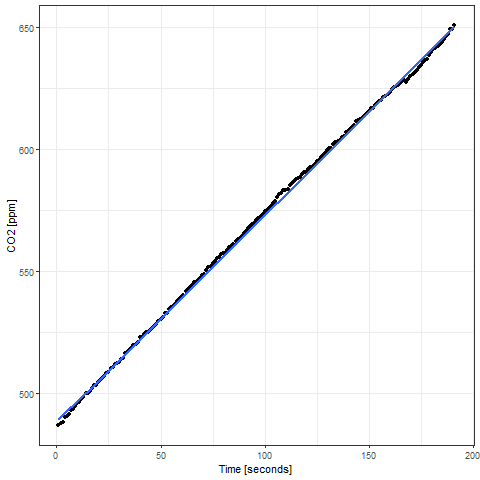

In [271]:
%%R

# Sample number
i <- 1

# Call calc_flux and remove data points at the start and/or at the end if necessary
calc_flux(info.data = info.data[i,],
          indata = sample.data[which(sample.data$Sample == i),],
          rmv_start = 0,
          rmv_end = 0)
    